In [8]:
# Importieren der Bibliotheken
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K


# Setzen der Plot-parameter
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Umformatieren des Intervals von einem 10-minütigen Intervall zu einem stündlichen-Intervall
csv_path = "../data/processed_weather_data_1H.csv"
df = pd.read_csv(csv_path)
predict_label = "T_(degC)"
time_label = "Date_Time"

date_time = pd.to_datetime(df.pop(time_label), format='%Y-%m-%d %H:%M:%S') #format='%d.%m.%Y %H:%M:%S')
date_time

0       2009-01-01 01:00:00
1       2009-01-01 02:00:00
2       2009-01-01 03:00:00
3       2009-01-01 04:00:00
4       2009-01-01 05:00:00
                ...        
70122   2016-12-31 19:00:00
70123   2016-12-31 20:00:00
70124   2016-12-31 21:00:00
70125   2016-12-31 22:00:00
70126   2016-12-31 23:00:00
Name: Date_Time, Length: 70127, dtype: datetime64[ns]

In [3]:
# Daten in Trainings-, Validierungs- und Test-sets aufteilen
# Diese Daten sind nicht gemischt (shuffel). Eine Mischung kann die zeitliche Abhängigkeit der Wetterdaten stören. => Wetterdaten können bestimmte Muster und Trends aufweisen, die auf der zeitlichen Reihenfolge der Daten basieren
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]

In [4]:
train_df.shape, val_df.shape, test_df.shape

((49088, 22), (10519, 22), (10520, 22))

In [5]:
# Die Normalisierung von Trainings-, Validierungs- und Testdaten ist wichtig, um unterschiedliche Skalen von Merkmalen auszugleichen, die Konvergenz des Modells zu verbessern und eine bessere allgemeine Leistung zu gewährleisten
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\Luca\AppData\Local\Temp\ipykernel_26768\3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


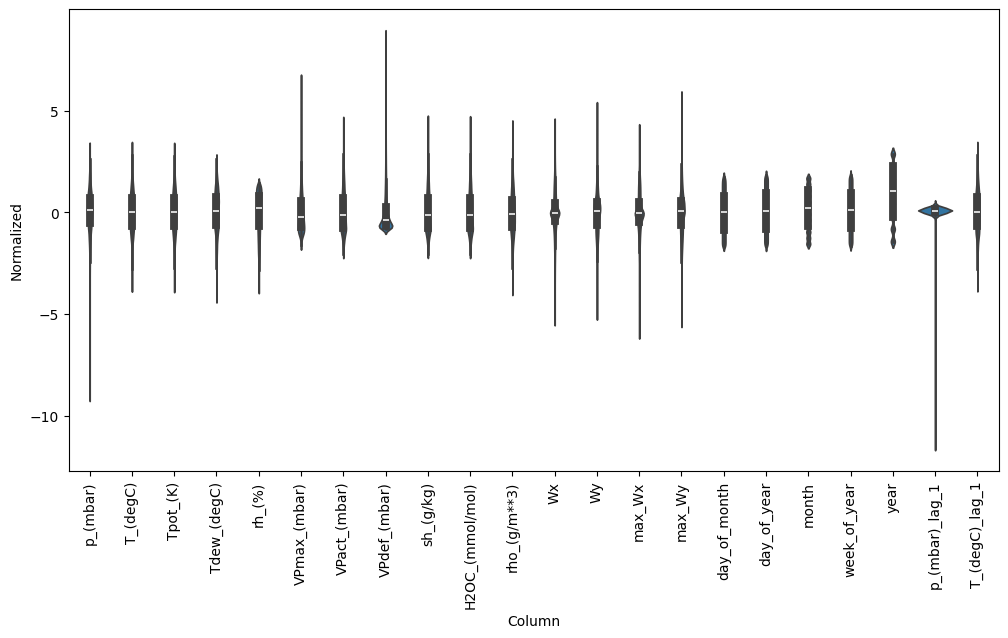

In [6]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [7]:
# Implementieren der Datenfenster. Es wird eine Vorhersage 24 Stunden in die Zukunft getroffen mit einer 24-stündigen Vergangenheit als Input
# Input_width => 24 multi_input
# offset = 24 => vorhersage bis zu 24 Stunden in die Zukunft
# label_width => 24 Multi_output schritte
input_width = 24
label_width  = 24
offset = 24
label_columns = ["T_(degC)"]

In [9]:
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [10]:
# Erstellen einer Funktionen, welche Feature-Fenster in (Features, Label)- Paare aufteilt und die Datasets mithilfe von tf.data.Datasets effizient stapelt.

class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Speichern der Rohdaten
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Ermitteln der Indizes der Label
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Ermitteln der Fensterparameter
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def plot(self, model=None, plot_col=predict_label, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index
            
            if label_col_index is None:
              continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
              plt.legend()
        
        plt.xlabel('Time [h]')
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    # Make_dataset-Methode konvertiert den Zeitreihen-DataFrame mithilfe der Funktion tf.keras.utils.timeseries_dataset_from_array in ein tf.data.Dataset aus (input_window, label_window)-Paaren:
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        return ds

    #Damit der tf.data.Dataset auf die training, Validierungs und test -sets zugreifen kann, müssen diese Daten in der Klasse leicht zugreifbar sein.
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)
    
    @property
    def val(self):
      return self.make_dataset(self.val_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      result = getattr(self, '_example', None)
      if result is None:
       
        result = next(iter(self.train))
    
        self._example = result
      return result

In [11]:
# Teilen der input- und label- fenster
def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
      #inputs.set_shape([None, self.input_width, None])
      #labels.set_shape([None, self.label_width, None])
    
      return inputs, labels

WindowGenerator.split_window = split_window

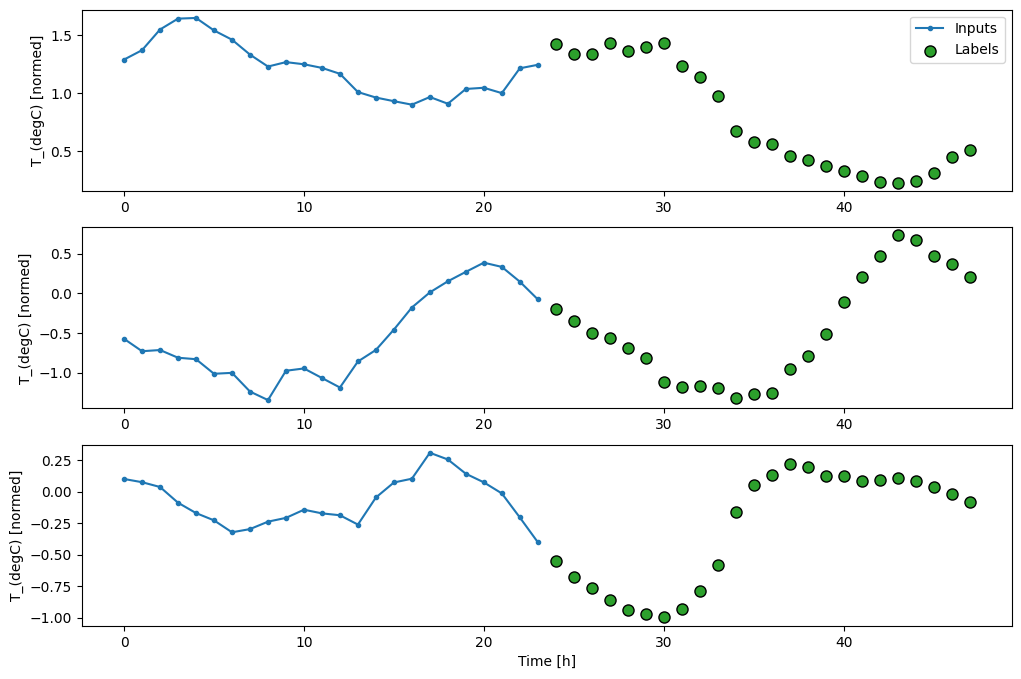

In [12]:
w1 = WindowGenerator(input_width=input_width, label_width=label_width, shift=offset) #, label_columns=['T (degC)']
w1.plot()


In [13]:
# Fenster
w1_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

w1_inputs, w1_labels = w1.split_window(w1_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {w1_window.shape}')
print(f'Inputs shape: {w1_inputs.shape}')
print(f'Labels shape: {w1_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 22)
Inputs shape: (3, 24, 22)
Labels shape: (3, 24, 22)


In [14]:
# Trainings Funktions
MAX_EPOCHS = 150

def compile_and_fit(model, window, patience=7):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), smape_loss])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [15]:
# Setzen der Attribute

val_performance = {}
performance = {}



328/328 [==============================] - 1s 2ms/step - loss: 0.2463 - mean_absolute_error: 0.3081 - mean_squared_error: 0.2463 - smape_loss: 0.4847


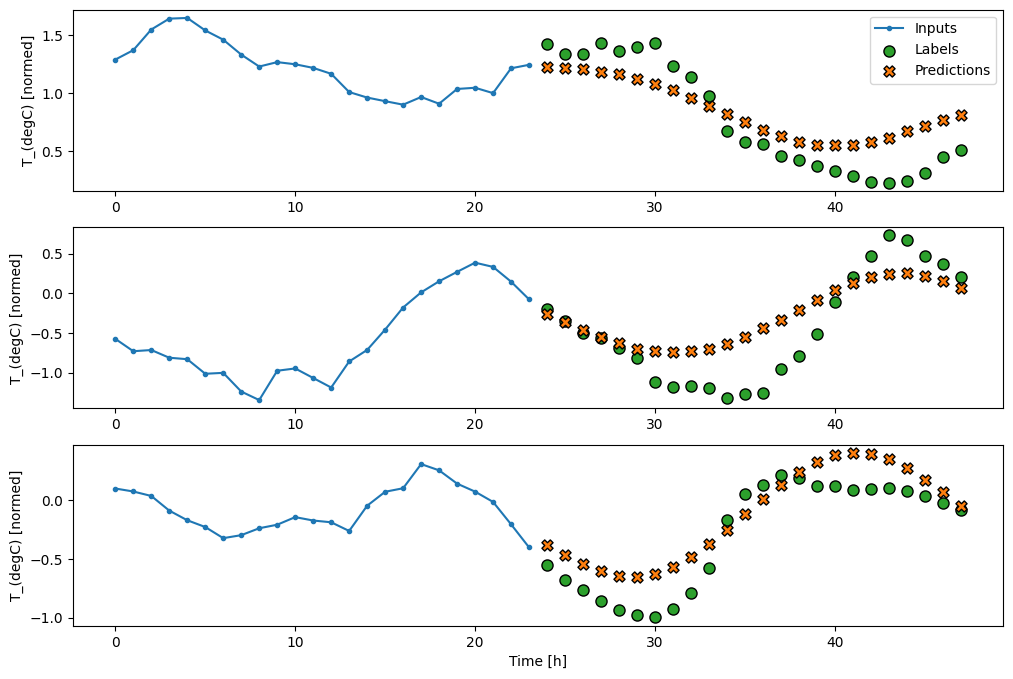

In [16]:
# LSTM - Model mit multi_output und multi_steps

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(offset*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([offset, num_features])
])

history = compile_and_fit(lstm_model, w1)

IPython.display.clear_output()

val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)
w1.plot(lstm_model)

In [17]:
# AR-RNN In Wetterdaten können vergangende Werte eine Auswirkung auf zukünftige Werte haben. Autoregressivität ermöglicht zeitliche Abhängigkeiten in Zeitreihen zu erfassen
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    # Die erste Methode, die dieses Modell benötigt, ist eine Aufwärmmethode, um seinen internen Zustand basierend auf den Eingaben zu initialisieren. Nach dem Training erfasst dieser Zustand die relevanten Teile des Eingabeverlaufs.
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)
        
        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        
        predictions = []
        
        prediction, state = self.warmup(inputs)
        
        
        predictions.append(prediction)
        
        
        for n in range(1, self.out_steps):
            
            x = prediction
            
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            
            prediction = self.dense(x)
            
            predictions.append(prediction)
        
        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


    

In [18]:
feedback_model = FeedBack(units=32, out_steps=offset)

In [19]:
# Diese Methode gibt eine einzelne Zeitschrittvorhersage und den internen Zustand des LSTM zurück.
prediction, state = feedback_model.warmup(w1.example[0])
prediction.shape

TensorShape([32, 22])

328/328 [==============================] - 1s 2ms/step - loss: 0.2651 - mean_absolute_error: 0.3328 - mean_squared_error: 0.2651 - smape_loss: 0.4979


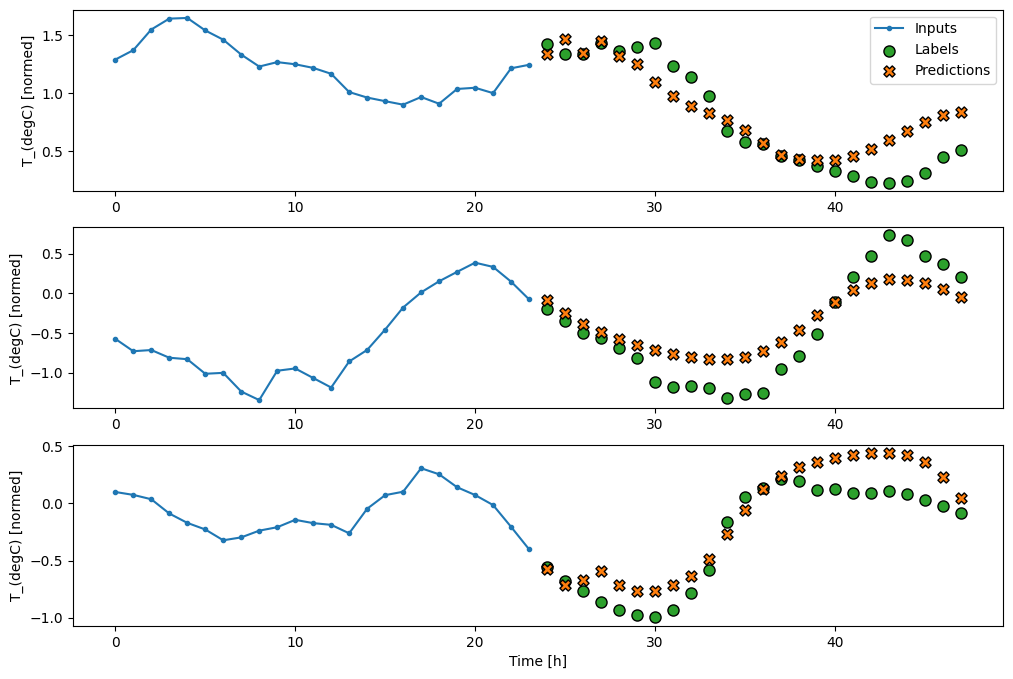

In [20]:
# Trainieren des Modells
history = compile_and_fit(feedback_model, w1)

IPython.display.clear_output()

val_performance['AR LSTM'] = feedback_model.evaluate(w1.val)
performance['AR LSTM'] = feedback_model.evaluate(w1.test, verbose=0)
w1.plot(feedback_model)

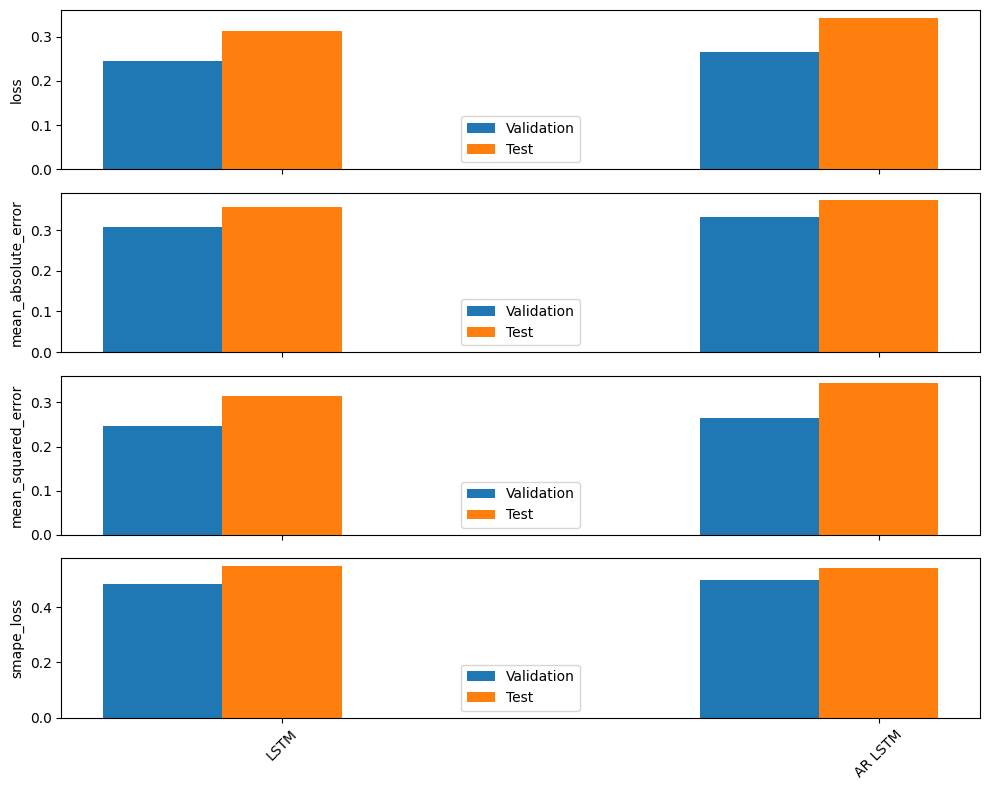

In [21]:
# Performancevergleich für alle Metriken
x = np.arange(len(performance))
width = 0.2  # Breite der Balken für jede Metrik

metrics = lstm_model.metrics_names

fig, axs = plt.subplots(len(metrics), figsize=(10, 8), sharex=True)

for i, metric_name in enumerate(metrics):
    metric_index = lstm_model.metrics_names.index(metric_name)

    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in performance.values()]

    axs[i].bar(x - 0.2, val_metric, width, label='Validation')
    axs[i].bar(x, test_metric, width, label='Test')
    axs[i].set_ylabel(metric_name)
    axs[i].legend()

plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.tight_layout()
plt.show()


In [22]:
metrics = lstm_model.metrics_names

for i, metric_name in enumerate(metrics):
    metric_index = lstm_model.metrics_names.index(metric_name)

    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in performance.values()]

    print(f"\nMetrik: {metric_name}")
    print("Validation:", val_metric)
    print("Test:", test_metric)


Metrik: loss
Validation: [0.2463335543870926, 0.26512330770492554]
Test: [0.3139403462409973, 0.3436768054962158]

Metrik: mean_absolute_error
Validation: [0.3080926835536957, 0.3328399956226349]
Test: [0.3553851842880249, 0.37289923429489136]

Metrik: mean_squared_error
Validation: [0.24633359909057617, 0.26512330770492554]
Test: [0.3139404058456421, 0.34367671608924866]

Metrik: smape_loss
Validation: [0.4846925735473633, 0.4978697597980499]
Test: [0.5497668385505676, 0.5435782670974731]


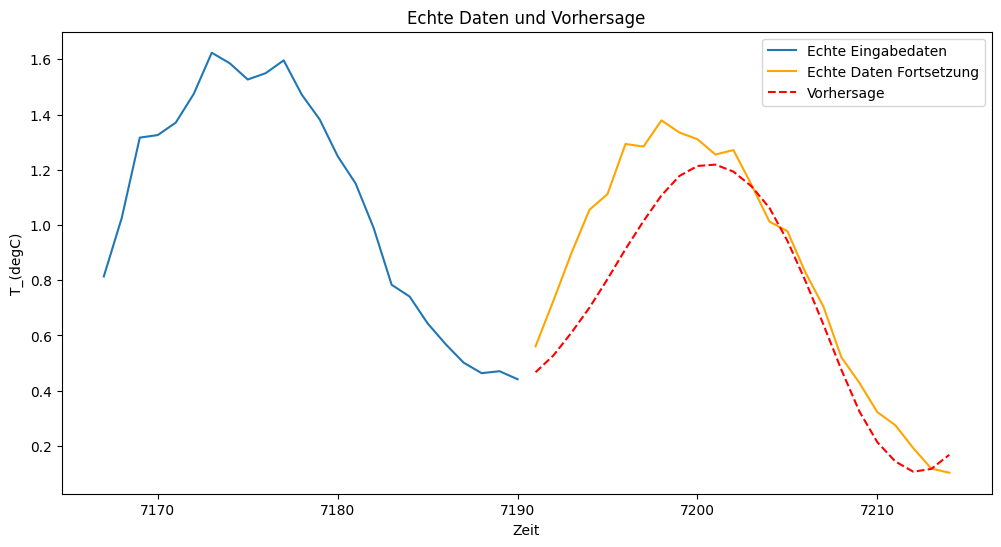

In [23]:
def make_single_prediction(model, window, test_df, plot=True):
    # Wählen einee zufällige Stichprobe aus dem Testdatensatz
    sample_index = np.random.randint(0, len(test_df) - window.total_window_size)
    sample = test_df[sample_index:sample_index + window.total_window_size]
    
    # Umwandeln der Stichprobe in ein Batch der Größe 1
    sample_batch = np.array(sample)[np.newaxis, ...]
    
    # Erstellen der Eingabe für das Modell
    inputs, _ = window.split_window(sample_batch)
    
    # Vorhersage mit dem Modell
    predictions = model(inputs)
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Plotten der echten Daten für das Eingabefenster
        time_axis_input = range(sample_index, sample_index + window.input_width)
        plt.plot(time_axis_input, np.array(sample)[:window.input_width, window.column_indices[predict_label]], label='Echte Eingabedaten')
        
        # Plotten der echten Daten als Fortsetzung
        time_axis_continuation = range(sample_index + window.input_width, sample_index + window.total_window_size)
        plt.plot(time_axis_continuation, np.array(sample)[window.input_width:, window.column_indices[predict_label]], label='Echte Daten Fortsetzung', color='orange')
        
        # Plotten der Vorhersage als Fortsetzung der echten Daten
        time_axis_prediction = range(sample_index + window.input_width, sample_index + window.input_width + window.label_width)
        plt.plot(time_axis_prediction, predictions[0, :, window.column_indices[predict_label]], label='Vorhersage', linestyle='--', color='red')
        
        plt.title('Echte Daten und Vorhersage')
        plt.xlabel('Zeit')
        plt.ylabel(predict_label)
        plt.legend()
        plt.show()

make_single_prediction(model=lstm_model, window=w1, test_df=test_df)

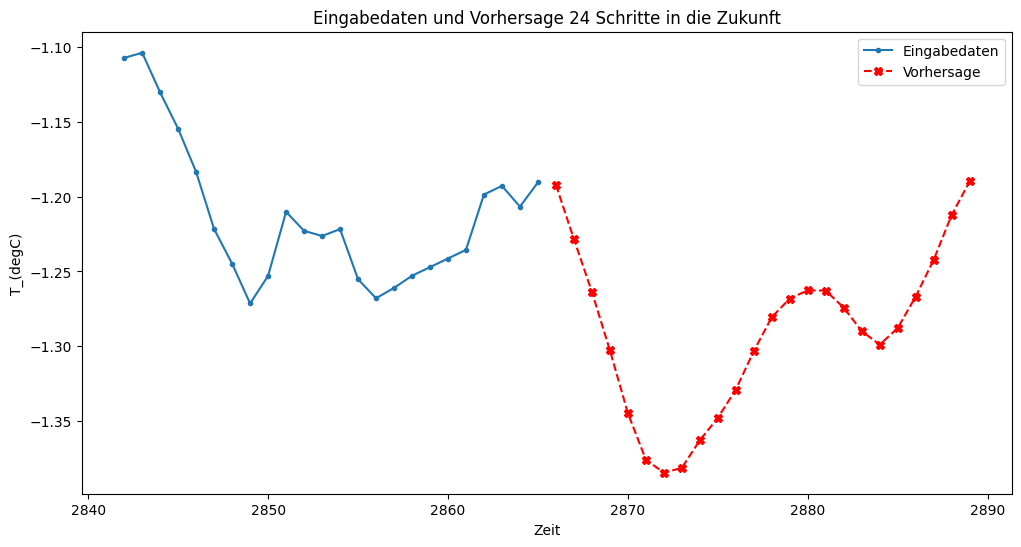

In [25]:
def make_single_prediction(model, window, test_df, plot=True):
    # Wählen einer zufällige Stichprobe aus dem Testdatensatz
    sample_index = np.random.randint(0, len(test_df) - window.total_window_size)
    sample = test_df[sample_index:sample_index + window.input_width]  # Eingabedaten für die Vorhersage

    # Umwandeln der Stichprobe in ein Batch der Größe 1
    sample_batch = np.array(sample)[np.newaxis, ...]

    # Vorhersage mit dem Modell
    predictions = model(sample_batch)

    if plot:
        plt.figure(figsize=(12, 6))
        input_time_axis = range(sample_index, sample_index + window.input_width)
        prediction_time_axis = range(sample_index + window.input_width, sample_index + window.input_width + window.label_width)

        # Plotten der echten Eingabedaten
        plt.plot(input_time_axis, np.array(sample)[:, window.column_indices[predict_label]], label='Eingabedaten', marker='.', zorder=-10)

        # Plotten der Vorhersage, 24 Schritte in die Zukunft
        plt.plot(prediction_time_axis, predictions[0, :, window.column_indices[predict_label]], 'r', label='Vorhersage', linestyle='--', marker='X')

        plt.title('Eingabedaten und Vorhersage 24 Schritte in die Zukunft')
        plt.xlabel('Zeit')
        plt.ylabel(predict_label)
        plt.legend()
        plt.show()

make_single_prediction(model=lstm_model, window=w1, test_df=test_df)
